In [151]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import datetime
import joblib
import time

In [152]:
file_path = 'car-manual-dataset/simulation-dataset.csv'
df = pd.read_csv(file_path)
#load a mannually generated dataset

print("Load dateset successful")
#df.info()
print("\nShowing first 5 lines:")
print(df.head())

Load dateset successful

Showing first 5 lines:
   run_id  time_step    d_front     d_back   v_front    v_back  ego_a
0       0          0  45.849370  22.924685  0.000000  0.000000    0.0
1       0          1  45.828807  22.945248 -0.411258  0.411258    3.0
2       0          2  45.769777  23.004278 -0.769341  0.769341    3.0
3       0          3  45.667066  23.106988 -1.284869  1.284869    3.0
4       0          4  45.525153  23.248901 -1.553389  1.553389    3.0


In [153]:
def classify_acceleration(a, threshold=0.05):
    if a > threshold:
        return 2  # speed up
    elif a < -threshold:
        return 0  # slow down
    else:
        return 1  # stay

# transfer the acceleration from -1.5, 0, 1.5 to class 0,1,2
df['action'] = df['ego_a'].apply(classify_acceleration)
print(df['action'].value_counts())

#define model input and output
FEATURE_COLUMNS = ['d_front', 'd_back', 'v_front', 'v_back']
LABEL_COLUMN = 'action'

X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24,stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled  = X_test_scaled.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)
print(f"TrainSet scale: {len(X_train_scaled)}")
print(f"TestSet scale: {len(X_test_scaled)}")

action
1    9362
2     412
0     236
Name: count, dtype: int64
TrainSet scale: 8008
TestSet scale: 2002


In [154]:
# Preprocessing using proper tensorflow dataset objects!
num_classes = len(np.unique(y_train))
input_size = X_train_scaled.shape[1]
# train_dataset = X_train_scaled
epochs = 10
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [155]:
# Simply using Katya's code, with output layer changed
def get_model(input_size, num_classes):
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(32, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    return model

In [156]:
# Train the model

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #set it to true if last layer is linear
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size, num_classes)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259 (1.01 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5212 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.3103 - val_sparse_categorical_accuracy: 0.9351
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2778 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.2519 - val_sparse_categorical_accuracy: 0.9351
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9351
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2108 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.1943 - val_sparse_categorical_accuracy: 0.9371
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1921 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.1781 - val_sparse_categorical_accuracy: 0.9431
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1795 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.1672 - val_sparse_categorical_accuracy: 0.9461

In [157]:
# Visalization, copied from Katya
def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Precision (macro): 0.9531
Recall (macro): 0.5065
F1-score (macro): 0.5679


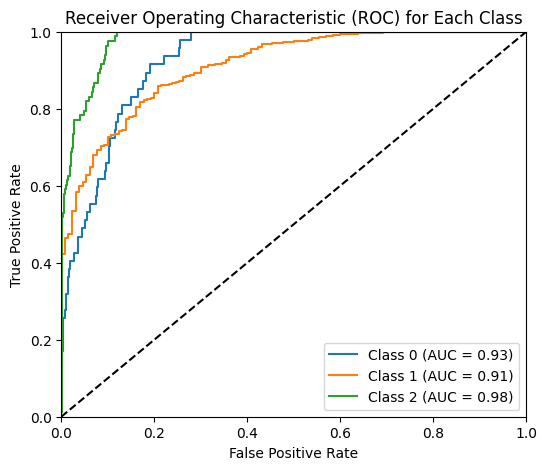

In [158]:
print_metrics(model_base, X_test_scaled, y_test, num_classes)

In [159]:
# Save the trained model, if you like
# model_folder = 'nn-models'
# os.makedirs(model_folder, exist_ok=True)
# timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# model_filename = f'nn_model_{timestamp_str}.keras'
# model_path = os.path.join(model_folder, model_filename)
# scaler_filename = f'scaler_{timestamp_str}.pkl'
# scaler_path = os.path.join(model_folder,scaler_filename)
# joblib.dump(scaler,scaler_path)
# model_base.save(model_path)
# print(f"model saved to {model_path}")

In [160]:
epsilon = 0.3
num_iter = 10
alpha = epsilon / num_iter #stops it from taking large steps in case of overshoot

In [161]:
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    '''
    Perform a PGD attack on the dataset.
    Args:
        model: trained keras model
        x: input data batch (d_front, d_back, v_front, v_back)
        y: true labels batch
        epsilon: maximum perturbation
        alpha: step size for each iteration
        num_iter: number of PGD iterations

    Returns adversarial examples.
    '''

    # ensure TF tensor and dtype matches model (usually float32)


    x = tf.convert_to_tensor(x)
    x = tf.cast(x, tf.float32)
    #baseline
    x_orig = tf.identity(x) #start from the original example
    x_adv = tf.identity(x_orig) #shape=(2002, 4)


    # uniform random start inside L_inf box (not great)
    # x_adv = x_orig + tf.random.uniform(tf.shape(x_orig), -epsilon, epsilon, dtype=x_orig.dtype)
    # x_adv = tf.clip_by_value(x_adv, x_orig - epsilon, x_orig + epsilon)


    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv) #watch because x_adv is a tensor
            predictions = model(x_adv, training=False)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions) # want to max
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, x_adv) # direction in which to most efficiently increase loss

        perturbations = tf.sign(gradients)  # use sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # update adversarial example

        # Project the adversarial example to ensure it's within epsilon-ball of the original image (imperceptible)
        x_adv = tf.clip_by_value(x_adv, x_orig - epsilon, x_orig + epsilon)


        x_adv = tf.stop_gradient(x_adv)
        if i == 0:
            print("Initial perturbation magnitude:", tf.reduce_mean(tf.abs(x_adv - x_orig)).numpy())
        if i == num_iter - 1:
            print("Final loss:", loss.numpy())

    # print("debug", x_adv.dtype, x_orig.dtype, tf.convert_to_tensor(epsilon, dtype=x_orig.dtype).dtype)
    # print("debug", x_adv.shape, x_orig.shape)
    return x_adv

Initial perturbation magnitude: 0.03
Final loss: 0.4003542
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
Accuracy on adversarial examples: 0.8282
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
Precision (macro): 0.3361
Recall (macro): 0.3605
F1-score (macro): 0.3375


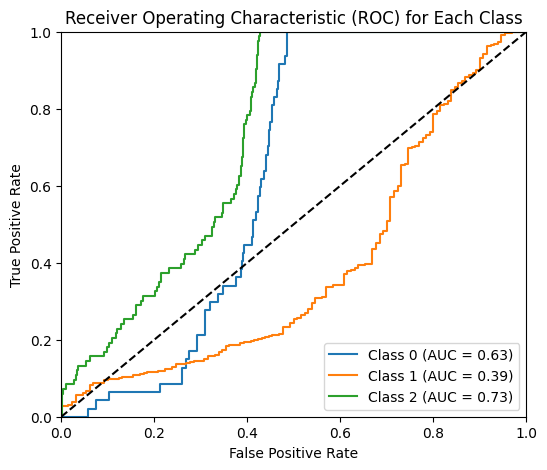

In [162]:
# Attack the model
x_test_sample = X_test_scaled
y_test_sample = y_test

# Generate adv examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate model on adv examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
print_metrics(model_base, x_test_adv, y_test_sample, num_classes)


In [163]:
# Adversarial training

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.

    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.

    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)

                # Forward pass
                logits = model(combined_x, training=True)

                # Compute the loss
                loss = loss_fn(combined_y, logits)

            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")

    return model

In [164]:
# Train adversarial model
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_adv = get_model(input_size, num_classes)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259 (1.01 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
Initial perturbation magnitude: 0.029999983
Final loss: 1.335753
Initial perturbation magnitude: 0.029999986
Final loss: 1.4014633
Initial perturbation magnitude: 0.029999986
Final loss: 1.3431485
Initial perturbation magnitude: 0.029999984
Final loss: 1.3193723
Initial perturbation magnitude: 0.029999984
Final loss: 1.3755951
Initial perturbation magnitude: 0.029999984
Final loss: 1.2708926
Initial perturbation magnitude: 0.029999984
Final loss: 1.3051318
Initial perturbation magnitude: 0.029999986
Final loss: 1.3206948
Initial perturbation magnitude: 0.029999986
Final loss: 1.2375572
Initial perturbation magnitude: 0.029999983
Final loss: 1.2932346
Initial perturbation magnitude: 0.029999984
Final loss: 1.2821131
Initial perturbation magnitude: 0.029999984
Final loss: 1.1957235
Initial perturbation magnitude: 0.02999998
Final loss: 1.2973208
Initial perturbation magnitude: 0.029999984
Final loss: 1.1943704
Initial perturbation magnitude: 0.029999984
Final loss: 1.2831

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision (macro): 0.6482
Recall (macro): 0.4137
F1-score (macro): 0.4533


K:\AutoDrive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


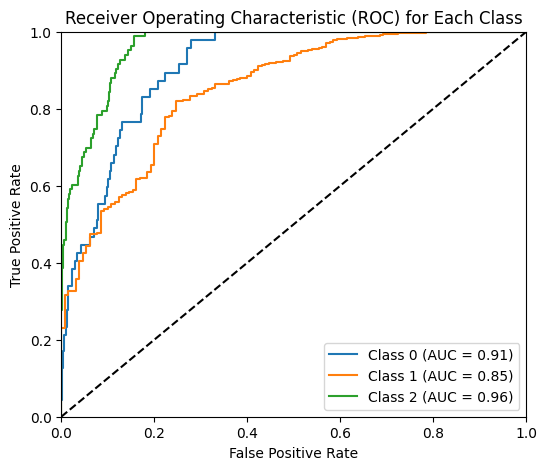

In [165]:
print_metrics(model_adv, X_test_scaled, y_test, num_classes)

Initial perturbation magnitude: 0.03
Final loss: 0.243855
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
Accuracy on adversarial examples: 0.9311
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
Precision (macro): 0.3451
Recall (macro): 0.3357
F1-score (macro): 0.3286


K:\AutoDrive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


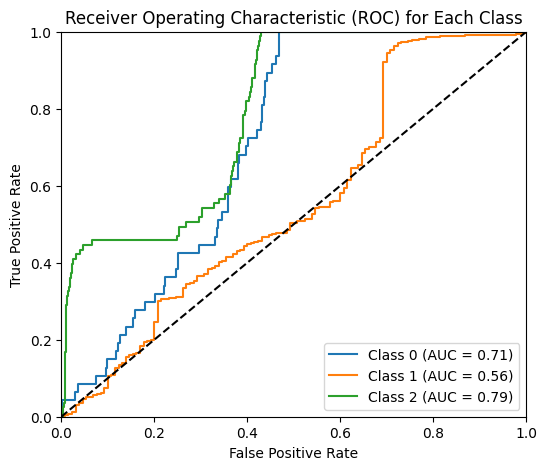

In [166]:
# Attack the new model
x_test_sample_ADV = X_test_scaled
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=40)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
print_metrics(model_adv, x_test_adv_ADV, y_test_sample_ADV, num_classes)